In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from matplotlib.collections import PatchCollection

In [3]:
from shapely.geometry import shape
import shapefile
import requests
from urllib import request
from zipfile import ZipFile
from io import BytesIO
from datetime import date
import osr

In [5]:
perimeter_url = 'https://rmgsc.cr.usgs.gov/outgoing/GeoMAC/historic_fire_data/US_HIST_FIRE_PERIMTRS_DD83.zip'

In [6]:
# Perimeters
zipfile = ZipFile(BytesIO(request.urlopen(perimeter_url).read()))
filenames = [y for y in sorted(zipfile.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
dbf, prj, shp, shx = [BytesIO(zipfile.read(filename)) for filename in filenames]
r = shapefile.Reader(shp=shp, shx=shx, dbf=dbf)
attributes, geometry = [], []
field_names = [field[0] for field in r.fields[1:]]  
for row in r.shapeRecords():  
    geometry.append(shape(row.shape.__geo_interface__))  
    attributes.append(dict(zip(field_names, row.record)))
        
try:
    proj4_string = osr.SpatialReference(str(prj.read())).ExportToProj4()
    perimeters = gpd.GeoDataFrame(data = attributes, geometry = geometry, crs = proj4_string)
except:
    perimeters = gpd.GeoDataFrame(data = attributes, geometry = geometry)

In [7]:
print(perimeters.shape)
print(perimeters.columns)
perimeters.head()

(23473, 10)
Index(['objectid', 'year_', 'acres', 'fire_name', 'unit_id', 'irwinid',
       'fire_num', 'st_area_sh', 'st_length_', 'geometry'],
      dtype='object')


,objectid,year_,acres,fire_name,unit_id,irwinid,fire_num,st_area_sh,st_length_,geometry
0,21999,2001,11059.673693,BACON POND,ID-SID,{00000000-0000-0000-0000-000000000000},2001-ID-SID-G290,0.004912,0.464703,"POLYGON ((-114.28942 42.60647, -114.28961 42.6..."
1,22000,2001,72.801837,S WALCOTT,ID-SID,{00000000-0000-0000-0000-000000000000},2001-ID-SID-G296,0.000032,0.033650,"POLYGON ((-113.42031 42.57474, -113.42039 42.5..."
2,22001,2001,15.452375,ROCK CREEK,ID-SID,{00000000-0000-0000-0000-000000000000},2001-ID-SID-G303,0.000007,0.012800,"POLYGON ((-114.31075 42.38745, -114.31054 42.3..."
3,22002,2001,101.092962,I84MP246,ID-SID,{00000000-0000-0000-0000-000000000000},2001-ID-SID-G308,0.000045,0.051676,"POLYGON ((-113.19283 42.31457, -113.19275 42.3..."
4,22003,2001,191.213671,HWY84MP18,ID-SID,{00000000-0000-0000-0000-000000000000},2001-ID-SID-G312,0.000085,0.037007,"POLYGON ((-113.47269 42.54494, -113.47181 42.5..."


In [8]:
# Latitude and longitude bounding box for San Diego county
MIN_LAT, MAX_LAT = 32.4, 33.6
MIN_LONG, MAX_LONG = -116, -118
sd_perimeters = perimeters.cx[MIN_LONG:MAX_LONG, MIN_LAT:MAX_LAT]
print(sd_perimeters.shape)
sd_perimeters.crs = {'init' :'epsg:4326'}
sd_perimeters = sd_perimeters.to_crs(epsg=3857)
sd_perimeters.head()

(284, 10)


,objectid,year_,acres,fire_name,unit_id,irwinid,fire_num,st_area_sh,st_length_,geometry
143,22137,2005,25.473090,SPICE,CA-MVU,{00000000-0000-0000-0000-000000000000},2005-CA-MVU-008761,0.000010,0.017150,"POLYGON ((-12991819.366 3853090.819, -12991797..."
171,22164,2005,100.177302,ROCK,CA-RRU,{00000000-0000-0000-0000-000000000000},2005-CA-RRU-062519,0.000039,0.027371,"POLYGON ((-12975315.964 3953267.876, -12975358..."
175,22168,2016,40.300000,PALA,CASCA,{00000000-0000-0000-0000-000000000000},2016-CASCA-007653,0.000016,0.027255,"MULTIPOLYGON (((-13034713.668 3951078.872, -13..."
262,22255,2000,11.268199,BARRETT DAM,CA-,{00000000-0000-0000-0000-000000000000},2000-CA-00000000,0.000004,0.009328,"POLYGON ((-12987809.503 3850526.986, -12987780..."
308,22302,2002,83.719271,LAGUNA,CA-,{00000000-0000-0000-0000-000000000000},2002-CA-,0.000033,0.023245,"POLYGON ((-13110018.896 3971543.266, -13109810..."


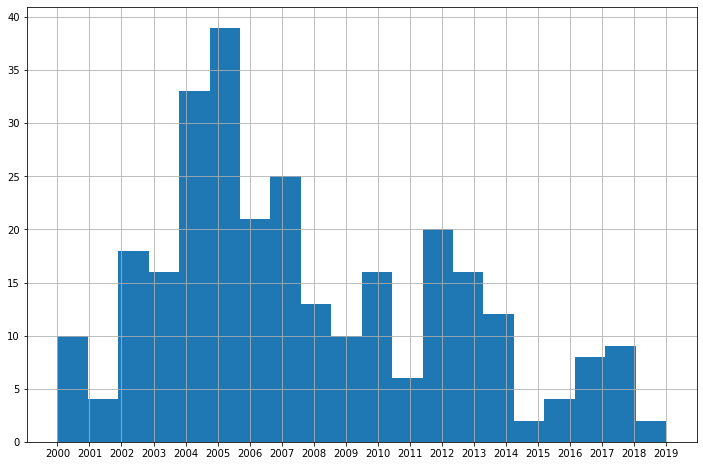

In [9]:
# shows how many fires over years 
n_bins = len(sd_perimeters.year_.astype(int).value_counts())
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sd_perimeters.year_.astype(int).hist(ax=ax, bins=n_bins)
low, hi  = sd_perimeters.year_.astype(int).min(), sd_perimeters.year_.astype(int).max()
ax.set_xticks(range(low, hi + 1));


In [25]:
# Top 10 year of fires 
t = sd_perimeters.year_.value_counts()
t.head(10)

2005    39
2004    33
2007    25
2006    21
2012    20
2002    18
2013    16
2003    16
2010    16
2008    13
Name: year_, dtype: int64

# recent years 
t.get(['2019'])

In [93]:
# recent years (5 years)
t.get(['2019','2018','2017','2016','2015'])

2019    2
2018    9
2017    8
2016    4
2015    2
Name: year_, dtype: int64

In [26]:
# how many attributes this dataframe has 
sd_perimeters.columns

Index(['objectid', 'year_', 'acres', 'fire_name', 'unit_id', 'irwinid',
       'fire_num', 'st_area_sh', 'st_length_', 'geometry'],
      dtype='object')

In [50]:
# Data is clean and there is no empty/missing vlaues 
sd_perimeters.isnull().count()

objectid      284
year_         284
acres         284
fire_name     284
unit_id       284
irwinid       284
fire_num      284
st_area_sh    284
st_length_    284
geometry      284
dtype: int64

In [51]:
sd_perimeters.head()

,objectid,year_,acres,fire_name,unit_id,irwinid,fire_num,st_area_sh,st_length_,geometry
143,22137,2005,25.473090,SPICE,CA-MVU,{00000000-0000-0000-0000-000000000000},2005-CA-MVU-008761,0.000010,0.017150,"POLYGON ((-12991819.366 3853090.819, -12991797..."
171,22164,2005,100.177302,ROCK,CA-RRU,{00000000-0000-0000-0000-000000000000},2005-CA-RRU-062519,0.000039,0.027371,"POLYGON ((-12975315.964 3953267.876, -12975358..."
175,22168,2016,40.300000,PALA,CASCA,{00000000-0000-0000-0000-000000000000},2016-CASCA-007653,0.000016,0.027255,"MULTIPOLYGON (((-13034713.668 3951078.872, -13..."
262,22255,2000,11.268199,BARRETT DAM,CA-,{00000000-0000-0000-0000-000000000000},2000-CA-00000000,0.000004,0.009328,"POLYGON ((-12987809.503 3850526.986, -12987780..."
308,22302,2002,83.719271,LAGUNA,CA-,{00000000-0000-0000-0000-000000000000},2002-CA-,0.000033,0.023245,"POLYGON ((-13110018.896 3971543.266, -13109810..."


In [67]:
dff=pd.read_csv('duplicated.csv')
duplicateRowsDF = dff[dff.duplicated(['acres'])]
duplicateRowsDF 

,objectid,year_,acres,fire_name,unit_id,irwinid,fire_num,st_area_sh,st_length_
5,21999,2001,11059.67369,BACON POND,ID-SID,{00000000-0000-0000-0000-000000000000},2001-ID-SID-G290,0.004912,0.464703


In [68]:
sd_perimeters.columns

Index(['objectid', 'year_', 'acres', 'fire_name', 'unit_id', 'irwinid',
       'fire_num', 'st_area_sh', 'st_length_', 'geometry'],
      dtype='object')

In [109]:
# As expected, there is no dupliciton for objectid but there is for irwinid
duplicateRowsDFd = sd_perimeters[sd_perimeters.duplicated(['irwinid'])]
print('Duplication of irwinid is ',duplicateRowsDFd.shape[0])
# As expected, there is duplication for unit_id as fires are reported with simialr stations. Similar obsrevation for irwinid 
duplicateRowsDFd = sd_perimeters[sd_perimeters.duplicated(['unit_id'])]
print('Duplication of unit id is expected as fire reported from similar places',duplicateRowsDFd.shape[0])
print('Total fires of SD county is ', sd_perimeters.shape[0])
duplicateRowsDFd.head()


Duplication of irwinid is  264
Duplication of unit id is expected as fire reported from similar places 266
Total fires of SD county is  284


,objectid,year_,acres,fire_name,unit_id,irwinid,fire_num,st_area_sh,st_length_,geometry
308,22302,2002,83.719271,LAGUNA,CA-,{00000000-0000-0000-0000-000000000000},2002-CA-,0.000033,0.023245,"POLYGON ((-13110018.896 3971543.266, -13109810..."
500,22494,2004,8.407588,BANDY,CA-MVU,{00000000-0000-0000-0000-000000000000},2004-CA-MVU-7357,0.000003,0.008094,"POLYGON ((-13025334.845 3904743.356, -13025303..."
538,22532,2007,103170.068234,HARRIS,CA-MVU,{00000000-0000-0000-0000-000000000000},2007-CA-MVU-D1Q7,0.040124,2.129742,"MULTIPOLYGON (((-13015614.384 3858746.885, -13..."
539,22533,2007,54639.092071,POOMACHA,CA-MVU,{00000000-0000-0000-0000-000000000000},2007-CA-MVU-D1SF,0.021404,1.078541,"MULTIPOLYGON (((-13020165.154 3949794.849, -13..."
589,22583,2010,109.520000,TENAJA,CA-CNF,{00000000-0000-0000-0000-000000000000},2010-CA-CNF-E9AV,0.000043,0.047050,"POLYGON ((-13069947.013 3974620.915, -13069893..."


In [103]:
# there is no duplication based 
duplicateRowsDF = sd_perimeters[sd_perimeters.duplicated(['fire_name'])]
print('Total of duplicated fire names are ', duplicateRowsDF.shape[0])
duplicateRowsDF.head(7)

Total of duplicated fire names are  52


,objectid,year_,acres,fire_name,unit_id,irwinid,fire_num,st_area_sh,st_length_,geometry
1858,23901,2002,1488.451496,ANTONIO,CA-,{00000000-0000-0000-0000-000000000000},2002-CA-,5.819915e-04,0.176837,"POLYGON ((-13090880.563 3977401.417, -13090907..."
3081,25101,2008,217.441728,MONTE,CA-MVU,{00000000-0000-0000-0000-000000000000},2008-CA-MVU-EEP4,8.480834e-05,0.040966,"POLYGON ((-13008846.499 3882816.682, -13008815..."
4205,26213,2010,38.910000,ROCK,CA-RRU,{00000000-0000-0000-0000-000000000000},2010-CA-RRU-73623,1.529462e-05,0.028001,"POLYGON ((-13056357.561 3975014.341, -13056356..."
4774,26783,2011,223.739025,PALA,CA-MVU,{00000000-0000-0000-0000-000000000000},2011-CA-MVU-GDS4,8.773914e-05,0.065567,"POLYGON ((-13032076.212 3947664.921, -13032076..."
6482,28482,2012,11667.140000,Vallecito Lightning Complex,CA-MVU,{00000000-0000-0000-0000-000000000000},2012-CA-MVU-G51T,4.565114e-03,0.511639,"POLYGON ((-12970984.373 3917858.095, -12970997..."
7341,29319,2004,2.498146,ANTONIO,CA-,{00000000-0000-0000-0000-000000000000},2004-CA-,9.818184e-07,0.006586,"MULTIPOLYGON (((-13095011.350 3972838.125, -13..."
7396,29372,2000,1322.127027,BARRETT,CA-,{00000000-0000-0000-0000-000000000000},2000-CA-00004431,5.145487e-04,0.116186,"POLYGON ((-12988082.417 3845118.049, -12988044..."


The fire with name ANTONIO happend in year of  2002


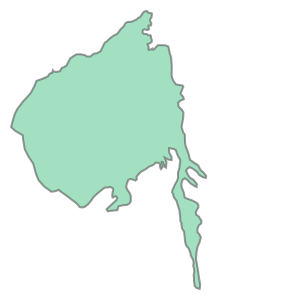

In [81]:
# Same fire name (Anton)
print('The fire with name ANTONIO happend in year of ', sd_perimeters.year_[1858])
sd_perimeters.geometry[1858]

The fire with name ANTONIO happend in year of  2004


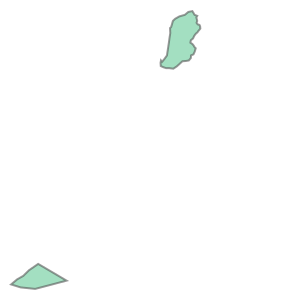

In [94]:
print('The fire with name ANTONIO happend in year of ', sd_perimeters.year_[7341])
sd_perimeters.geometry[7341]

In [39]:
sd_perimeters.geometry.head()

143    POLYGON ((-12991819.366 3853090.819, -12991797...
171    POLYGON ((-12975315.964 3953267.876, -12975358...
175    MULTIPOLYGON (((-13034713.668 3951078.872, -13...
262    POLYGON ((-12987809.503 3850526.986, -12987780...
308    POLYGON ((-13110018.896 3971543.266, -13109810...
Name: geometry, dtype: geometry

In [40]:
# centroids shows where burn is concentrated 
sd_perimeters.geometry.head().centroid.x

143   -1.299224e+07
171   -1.297592e+07
175   -1.303451e+07
262   -1.298788e+07
308   -1.310972e+07
dtype: float64

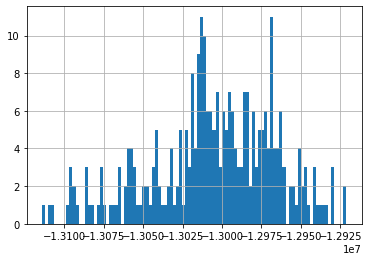

In [33]:
sd_perimeters.geometry.centroid.x.hist(bins=100)
# Mostly negative values as it toward ssouthern california

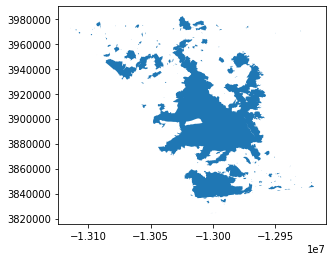

In [38]:
# figure below shows where mostly fire are concering 
sd_mask = sd_perimeters.geometry.centroid.x < 0
sd_perimeters[sd_mask].geometry.plot()

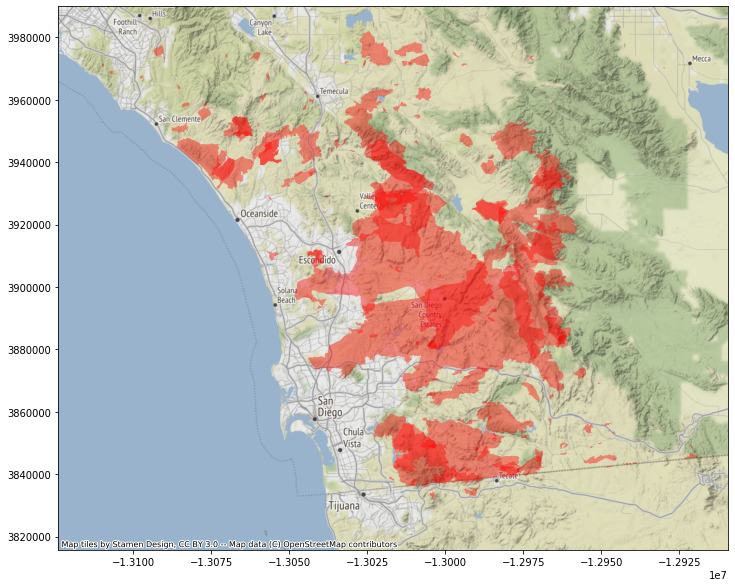

In [41]:
f, ax = plt.subplots(1, figsize=(12, 12))
sd_perimeters.plot(ax=ax, color='red', alpha=.4)
ctx.add_basemap(ax)

In [119]:
sd_perimeters.head()

,objectid,year_,acres,fire_name,unit_id,irwinid,fire_num,st_area_sh,st_length_,geometry
143,22137,2005,25.473090,SPICE,CA-MVU,{00000000-0000-0000-0000-000000000000},2005-CA-MVU-008761,0.000010,0.017150,"POLYGON ((-12991819.366 3853090.819, -12991797..."
171,22164,2005,100.177302,ROCK,CA-RRU,{00000000-0000-0000-0000-000000000000},2005-CA-RRU-062519,0.000039,0.027371,"POLYGON ((-12975315.964 3953267.876, -12975358..."
175,22168,2016,40.300000,PALA,CASCA,{00000000-0000-0000-0000-000000000000},2016-CASCA-007653,0.000016,0.027255,"MULTIPOLYGON (((-13034713.668 3951078.872, -13..."
262,22255,2000,11.268199,BARRETT DAM,CA-,{00000000-0000-0000-0000-000000000000},2000-CA-00000000,0.000004,0.009328,"POLYGON ((-12987809.503 3850526.986, -12987780..."
308,22302,2002,83.719271,LAGUNA,CA-,{00000000-0000-0000-0000-000000000000},2002-CA-,0.000033,0.023245,"POLYGON ((-13110018.896 3971543.266, -13109810..."


In [ ]:
df = pd.DataFrame(s).reset_index()
df.columns = ['Gene', 'count']
df

In [182]:
a = sd_perimeters.acres.astype(int)
a= pd.DataFrame(a, columns=['acres'])


In [216]:
#a1 = 0<=sd_perimeters['acres']<22
a1=sd_perimeters['acres']>=0
a2 = sd_perimeters['acres']<22
a3 = a1 & a2
a4=sd_perimeters['acres']>=22
a5=sd_perimeters['acres']<103.5
a6 = sd_perimeters['acres']>=103.5
a7=sd_perimeters['acres'] <417
a8= sd_perimeters['acres']>=417
sd_perimeters[a7].count()


objectid      213
year_         213
acres         213
fire_name     213
unit_id       213
irwinid       213
fire_num      213
st_area_sh    213
st_length_    213
geometry      213
dtype: int64

In [220]:
sd_perimeters['acres'].describe()

count       284.000000
mean       4371.554720
std       24940.429029
min           0.469528
25%          22.147701
50%         103.950398
75%         417.480840
max      288368.808155
Name: acres, dtype: float64

[70 72 71 71]


(array([1., 0., 0., 0., 0., 2., 0., 0., 0., 1.]),
 array([70. , 70.2, 70.4, 70.6, 70.8, 71. , 71.2, 71.4, 71.6, 71.8, 72. ]),
 <a list of 10 Patch objects>)

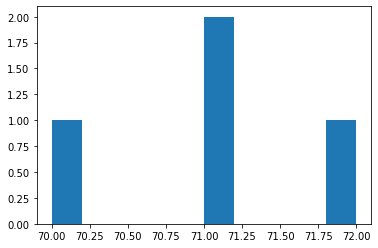

In [214]:
# how many fires around 0 to 22
aa = [sd_perimeters[a2].shape[0], sd_perimeters[a4 & a5].shape[0], sd_perimeters[a6 & a7].shape[0], sd_perimeters[a8].shape[0]]
aa = np.array(aa)
print(aa),
hight= [60,70,71,71]
plt.hist(aa)


In [ ]:
fig_dims = (12, 8)
fig, a = plt.subplots(figsize=fig_dims)
a = sd_perimeters.acres_.astype(int).hist(a=a, bins=n_bins)
low, hi  = sd_perimeters.year_.astype(int).min(), sd_perimeters.year_.astype(int).max()
a.set_xticks(range(low, hi + 1));